In [17]:
## import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import warnings
warnings.filterwarnings("ignore")


In [19]:

## connect and create database
conn = sqlite3.connect("olist_ecommerce.sqlite")

## map CSV file
files = {
    "olist_orders_dataset.csv": "orders_dataset",
    "olist_order_items_dataset.csv": "order_items_dataset",
    "olist_order_payments_dataset.csv": "order_payments_dataset",
    "olist_customers_dataset.csv": "customers_dataset",
    "olist_products_dataset.csv": "products_dataset",
    "olist_sellers_dataset.csv": "sellers_dataset",
    "product_category_name_translation.csv": "product_category_name_translation",
    "olist_order_reviews_dataset.csv":"order_reviews_dataset"
}

# Import all CSVs into SQLite
for csv_file, table_name in files.items():
    df = pd.read_csv(csv_file)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print(f"{table_name} imported successfully")

# Set Seaborn style for visualization
sns.set_theme(style="whitegrid", palette="deep")


orders_dataset imported successfully
order_items_dataset imported successfully
order_payments_dataset imported successfully
customers_dataset imported successfully
products_dataset imported successfully
sellers_dataset imported successfully
product_category_name_translation imported successfully
order_reviews_dataset imported successfully


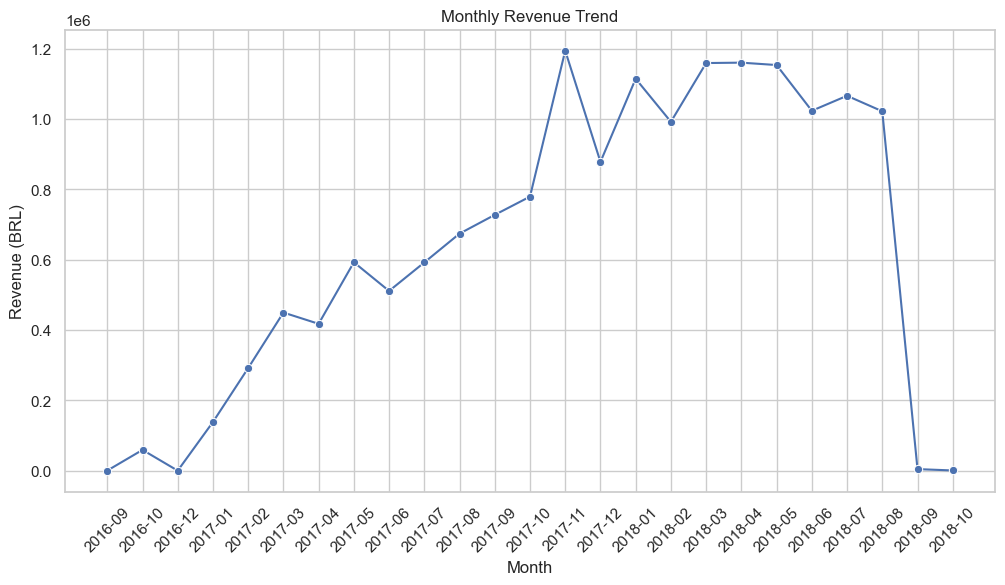

In [20]:
### E-commerce sales trend analysis or business KPI

query1 = """
SELECT strftime('%Y-%m', order_purchase_timestamp) AS month,
       SUM(payment_value) AS revenue
FROM orders_dataset
JOIN order_payments_dataset USING(order_id)
GROUP BY month
ORDER BY month;
"""
df_monthly = pd.read_sql_query(query1, conn)

plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthly, x="month", y="revenue", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (BRL)")
plt.show()


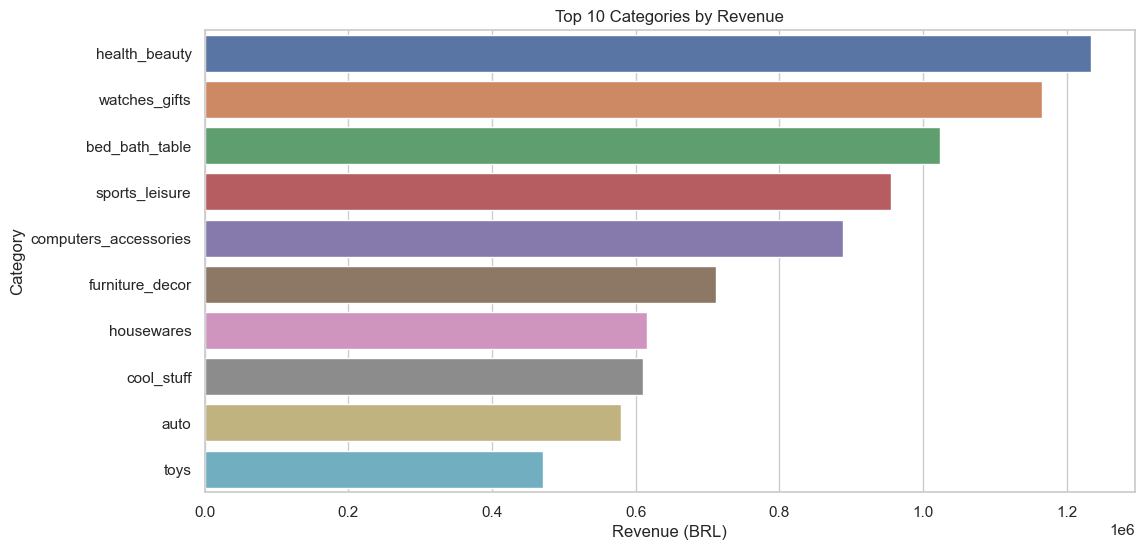

In [21]:
## Product category that earn most

query2 = """
SELECT pc.product_category_name_english as category,
       ROUND(SUM(oi.price),2) AS total_sales,
       COUNT(DISTINCT od.order_id) AS order_count
FROM order_items_dataset as oi
JOIN products_dataset as pd USING(product_id)
JOIN orders_dataset as od USING(order_id)
JOIN product_category_name_translation as pc ON pc.product_category_name = pd.product_category_name
WHERE od.order_status = 'delivered'
GROUP BY category
ORDER BY total_sales DESC
LIMIT 10;
"""
df_category = pd.read_sql_query(query2, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=df_category, x="total_sales", y="category")
plt.title("Top 10 Categories by Revenue")
plt.xlabel("Revenue (BRL)")
plt.ylabel("Category")
plt.show()

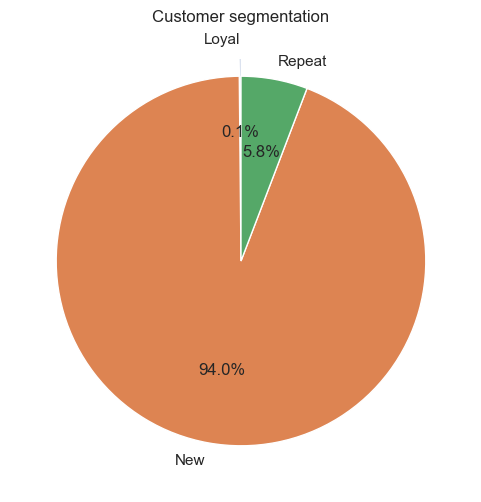

In [22]:
##--CUSTOMer analysis 

query = """
WITH customer_orders AS (
  SELECT c.customer_unique_id,
         COUNT(o.order_id) AS total_orders,
         SUM(p.payment_value) AS total_spend
  FROM customers_dataset AS c
  JOIN orders_dataset AS o 
    ON c.customer_id = o.customer_id
  JOIN order_payments_dataset AS p 
    ON o.order_id = p.order_id
  GROUP BY c.customer_unique_id
),
customer_segments AS (
  SELECT customer_unique_id,
         total_orders,
         total_spend,
         CASE
           WHEN total_orders = 1 THEN 'New'
           WHEN total_orders BETWEEN 2 AND 5 THEN 'Repeat'
           ELSE 'Loyal'
         END AS segment
  FROM customer_orders
)
SELECT segment,
       COUNT(*) AS customer_count
FROM customer_segments
GROUP BY segment;

"""
df_segment = pd.read_sql_query(query, conn)

sizes = df_segment['customer_count']
labels=df_segment['segment']
explode = [0.1 if i == sizes.min() else 0 for i in sizes]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90, explode=explode)
plt.title('Customer segmentation')
plt.show()


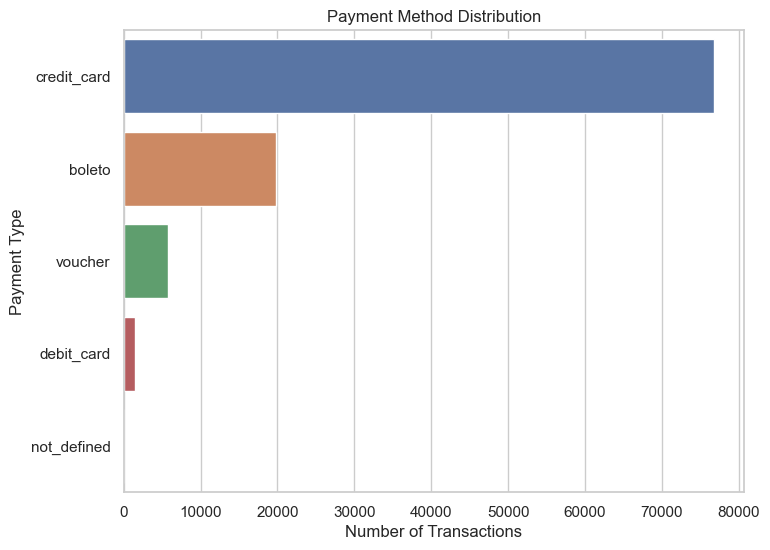

In [23]:
## Payment method distribution

query = """
SELECT payment_type, COUNT(*) AS count
FROM order_payments_dataset
GROUP BY payment_type
ORDER BY count DESC;
"""
df_payment = pd.read_sql_query(query, conn)

plt.figure(figsize=(8,6))
sns.barplot(data=df_payment, x="count", y="payment_type")
plt.title("Payment Method Distribution")
plt.xlabel("Number of Transactions")
plt.ylabel("Payment Type")
plt.show()


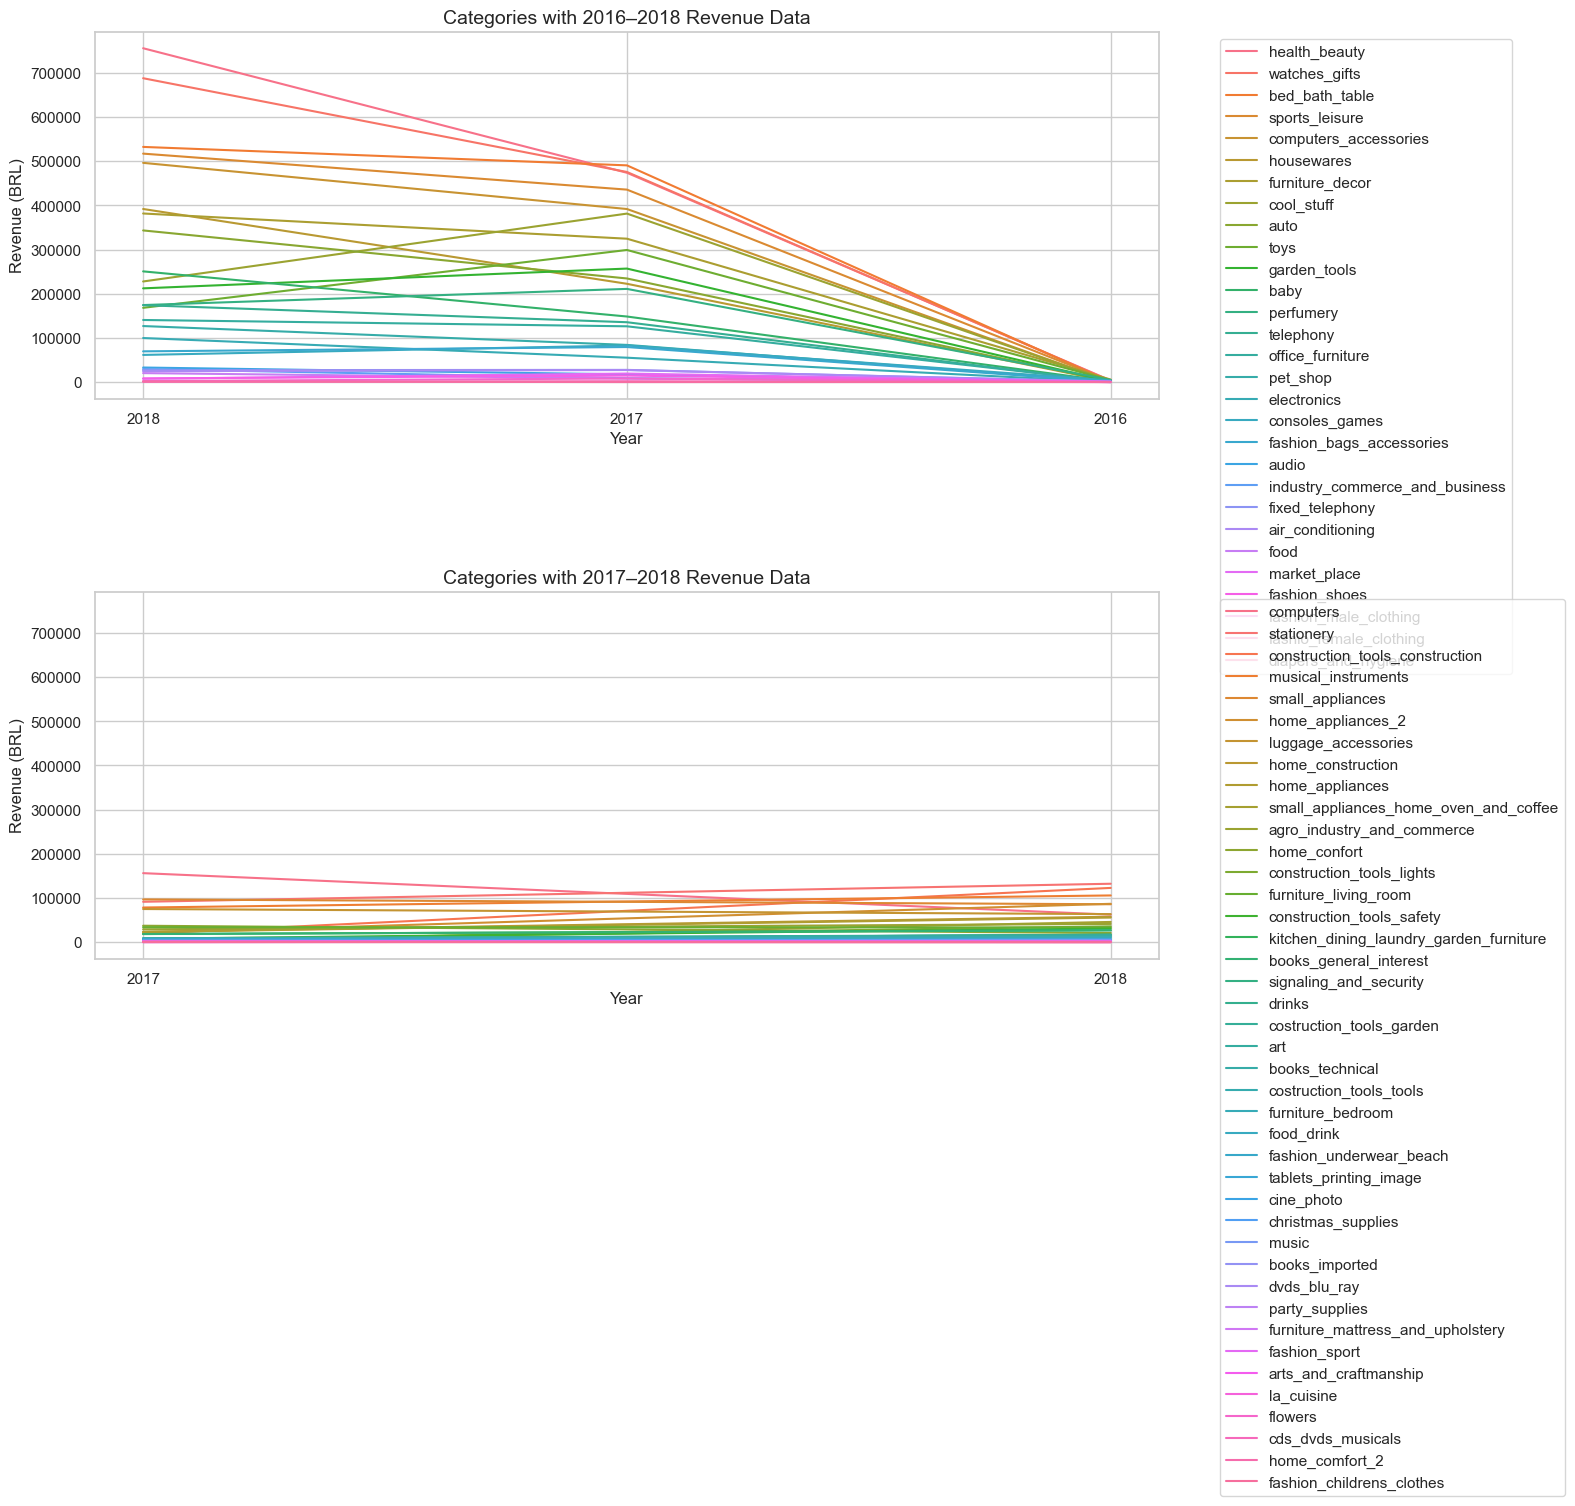

In [24]:
## revenue of each category of year 2016-18

query = """
---“Top 5 categories with highest year-over-year growth.”

WITH sales_by_year AS (
  SELECT pct.product_category_name_english AS category,
         strftime('%Y', o.order_purchase_timestamp) AS year,
         SUM(oi.price) AS revenue
  FROM order_items_dataset oi
  JOIN products_dataset p USING(product_id)
  JOIN product_category_name_translation pct USING(product_category_name)
  JOIN orders_dataset o USING(order_id)
  WHERE o.order_status = 'delivered'
  GROUP BY pct.product_category_name_english, year
)
SELECT category,
       year,
       revenue,
       ROUND(
         (revenue - LAG(revenue) OVER(PARTITION BY category ORDER BY year)) 
         / LAG(revenue) OVER(PARTITION BY category ORDER BY year) * 100, 2
       ) AS yoy_growth
FROM sales_by_year
ORDER BY revenue DESC, year DESC
;

"""
df_yoy = pd.read_sql_query(query,conn)



# Year count per category 
year_count = df_yoy.groupby("category")["year"].nunique().reset_index() 
year_count.rename(columns={"year":"year_count"}, inplace=True) 
# Merge back to original dataframe 
df_yoy = df_yoy.merge(year_count, on="category") 
# Group 1: Categories with 3 years of data (2016–2018) 
df_group1 = df_yoy[(df_yoy["year"].isin(["2016","2017","2018"])) & (df_yoy["year_count"] == 3)] 
# Group 2: Categories with only 2 years of data (2017–2018) 
df_group2 = df_yoy[(df_yoy["year"].isin(["2017","2018"])) & (df_yoy["year_count"] == 2)]
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharey=True)  # 2 row, 1 column

# Graph 1: 2016–2018 categories
sns.lineplot(data=df_group1, x="year", y="revenue", hue="category", ax=axes[0])
axes[0].set_title("Categories with 2016–2018 Revenue Data", fontsize=14)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Revenue (BRL)")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Graph 2: 2017–2018 categories
sns.lineplot(data=df_group2, x="year", y="revenue", hue="category", ax=axes[1])
axes[1].set_title("Categories with 2017–2018 Revenue Data", fontsize=14)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Revenue (BRL)")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



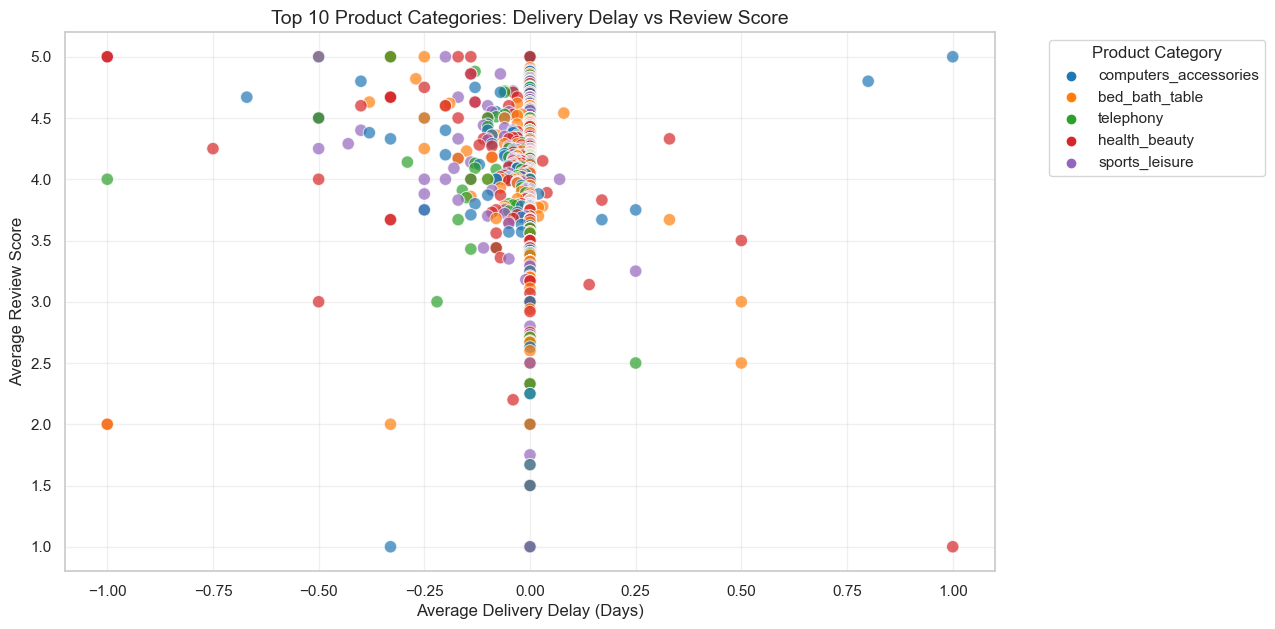

In [25]:
## scatter plot of correlation between delevary time and rating 

query = """
SELECT cd.customer_city, ce.product_category_name_english,
       ROUND(AVG(ord.review_score),2) AS avg_review,
	   ROUND(AVG(od.order_delivered_customer_date - od.order_estimated_delivery_date), 2) AS avg_delay
FROM orders_dataset as od
JOIN order_items_dataset as oi ON od.order_id = oi.order_id
JOIN products_dataset as pd ON pd.product_id = oi.product_id
JOIN product_category_name_translation as ce ON pd.product_category_name = ce.product_category_name
JOIN customers_dataset as cd USING(customer_id)
JOIN order_reviews_dataset as ord USING(order_id)
WHERE od.order_status = 'delivered'
GROUP BY cd.customer_city
ORDER BY avg_review DESC, avg_delay DESC;

"""
df_corr = pd.read_sql_query(query, conn)
# Top 10 categories by number of rows (orders)
top10 = (
    df_corr['product_category_name_english']
    .value_counts()
    .head(5)
    .index
)

df_top10 = df_corr[df_corr['product_category_name_english'].isin(top10)]

# Scatter plot without regression line
plt.figure(figsize=(12,7))
sns.scatterplot(
    data=df_top10,
    x="avg_delay",
    y="avg_review",
    hue="product_category_name_english",
    palette="tab10",
    s=80,
    alpha=0.7
)

plt.title("Top 10 Product Categories: Delivery Delay vs Review Score", fontsize=14)
plt.xlabel("Average Delivery Delay (Days)")
plt.ylabel("Average Review Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

